In [1]:
import pandas as pd
import numpy as np
import os,sys,time,pickle
from math import sin, cos, degrees, radians
from ase import Atoms
from ase.calculators.vasp import VaspChargeDensity

from pymatgen.core.structure import Structure, Lattice
from pymatgen.io.vasp.inputs import Poscar

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.interpolate import griddata, LinearNDInterpolator
from scipy import interpolate
from scipy.ndimage import rotate
import scipy.ndimage as ndimage

import pylab as pl

#import scipy.interpolate as interpolate
#from scipy.interpolate import griddata

In [ ]:
path_AB = '/home/shj/PbS_ligand_effect/100/pentDT/total' 
path_A = '/home/shj/PbS_ligand_effect/100/pentDT/surf' 
path_B = '/home/shj/PbS_ligand_effect/100/pentDT/ligand'

# CHGDIFF

In [7]:
os.chdir(path_AB)
os.system('(echo 314; echo '+path_AB+'/CHGCAR '+path_A+'/CHGCAR '+path_B+'/CHGCAR )'+' | vaspkit >/dev/null 2>&1')

0

# CHGDIFF 읽기

In [8]:
os.chdir(path_AB)
chgdiff = 'CHGDIFF.vasp'
atoms = 'POSCAR'

In [10]:
def find_started_line():
    line_number = 0
    with open(chgdiff, 'r') as file:
        for number, line in enumerate(file, start=1):
            if line == ' \n' or line == ' ' or line == '' or line == '\n':
                line_number = number+1
    return line_number

In [11]:
line_start = find_started_line()

In [12]:
# read CHGCAR using ase
start= time.time()
sys.stdout.write("Reading CHGCAR... "); sys.stdout.flush()
CHGCAR = VaspChargeDensity(chgdiff)
end= time.time()
print("finished. {0}".format(end-start))

Reading CHGCAR... finished. 8.261133909225464


In [ ]:
a = open(chgdiff)
b = a.readlines()

In [14]:
cell= CHGCAR.atoms[0].cell # cell_volume
nx,ny,nz= np.shape(CHGCAR.chg[0]) # grid
chg_den = np.array(CHGCAR.chg).reshape(-1)

latx = cell[0][0]
laty = cell[1][1]
latz = cell[2][2]

Line = int(np.ceil((nx*ny*nz/5.0)))

In [ ]:
val = []
for i in range(line_start,line_start+Line):
    temp = list(map(float, b[i].split()))
    val += temp

In [16]:
vol = latx*laty*latz
val = np.asarray(val)/vol
val = val.reshape(nz, ny, nx)

In [17]:
x = np.linspace(0, latx, nx, endpoint=False)
y = np.linspace(0, laty, ny, endpoint=False)
z = np.linspace(0, latz, nz, endpoint=False)

# Direction

In [ ]:
axis = int(input('axis: '))

if axis == 0: # view along the c axis
    x_set = x
    y_set = y
    rotation = 0
    
if axis == 1: # view along the b axis
    x_set = x
    y_set = z
    rotation = 90
    
if axis == 2:
    x_set = y
    y_set = z
    rotation = 90

axis를 설정하세요: 1


In [ ]:
z_aver_chg_den = np.mean(val, axis=axis)
z_aver_chg_den.shape

(320, 168)

In [ ]:
z_aver_chg_den = rotate(z_aver_chg_den, rotation)
z_aver_chg_den.shape

(168, 320)

# Interpolate

## Rbf

In [ ]:
# X, Y = np.mgrid[z.min():z.max():complex(str(z_aver_chg_den.shape[0])+'j'), y.min():y.max():complex(str(z_aver_chg_den.shape[1])+'j')]
# y_rbf = interpolate.Rbf(X.ravel(), Y.ravel(), z_aver_chg_den.ravel(), smooth=0.00001)
# Z = y_rbf(X, Y)

## LinearNDInterpolator

In [22]:
X, Y = np.mgrid[x_set.min():x_set.max():complex(str(z_aver_chg_den.shape[0])+'j'), y_set.min():y_set.max():complex(str(z_aver_chg_den.shape[1])+'j')]
interp = LinearNDInterpolator(list(zip(X.ravel(), Y.ravel())), z_aver_chg_den.ravel())
Z = interp(X, Y)

In [23]:
print('min: ', min(Z.ravel()))
print('max: ', max(Z.ravel()))

min:  -0.012572467882565918
max:  0.0114201619145728


# atomic postition

In [24]:
poscar = Poscar.from_file(atoms)
structure = poscar.structure

In [25]:
atomic_position = structure.cart_coords
atomic_tag = [str(i).split() for i in structure.species]
atom_list = np.hstack((atomic_position, atomic_tag))

In [26]:
df_atomic_position = pd.DataFrame(atom_list, columns=['x', 'y', 'z', 'tag'])
df_atomic_position = df_atomic_position.astype({'x' : 'float', 'y' : 'float', 'z' : 'float', 'tag' : 'string'})
df_atomic_position.head()

,x,y,z,tag
0,9.869524,2.222416,19.563280,H
1,7.933842,4.847369,19.083016,H
2,9.697489,4.807114,19.184293,H
3,8.006603,3.420044,17.006879,H
4,9.767271,3.390685,17.079269,H


In [27]:
# df_atomic_position['x'] = abs(df_atomic_position.loc[:, 'x'] - df_atomic_position.loc[:, 'x'].max())
# df_atomic_position.head()

In [28]:
#df_atomic_position = df_atomic_position[((4 < df_atomic_position['y']) & (df_atomic_position['y'] < 7)) | (12 < df_atomic_position['z'])]
# df_atomic_position = df_atomic_position[((5 < df_atomic_position['y']) & (df_atomic_position['y'] < 7) & (13 > df_atomic_position['y'])) | (13 < df_atomic_position['z'])]
df_atomic_positiondf_atomic_position[((5 < df_atomic_position['y']) & (df_atomic_position['y'] < 7) & (13 > df_atomic_position['y'])) | (13 < df_atomic_position['z'])]

df_atomic_position

,x,y,z,tag
0,9.869524,2.222416,19.563280,H
1,7.933842,4.847369,19.083016,H
2,9.697489,4.807114,19.184293,H
3,8.006603,3.420044,17.006879,H
4,9.767271,3.390685,17.079269,H
5,8.069526,5.937230,16.743393,H
6,9.834062,5.891377,16.779611,H
7,9.902379,6.909654,14.395424,H
8,8.131705,6.959279,14.393672,H
9,8.068529,4.456761,14.703496,H


In [29]:
tag_dataframes = {}

# Get unique tags in the DataFrame
unique_tags = df_atomic_position['tag'].unique()

# Split DataFrame by tag
for tag in unique_tags:
    tag_dataframes[tag] = df_atomic_position[df_atomic_position['tag'] == tag]

# Access each DataFrame using the tag as the key
H_df = tag_dataframes['H']
Pb_df = tag_dataframes['Pb']
C_df = tag_dataframes['C']
# O_df = tag_dataframes['O']
S_df = tag_dataframes['S']

# CHGCAR Plot

In [41]:
def plot(X, Y, Z):
    
    fig = plt.figure(figsize=(10,10))  # (100) 정사각 - 10,7 # (111) - 8,10
    ax = plt.axes()
    
    lw = 1.5
    levels=15 # 8
    vmin = -0.015
    vmax = 0.015
    cmap = "bwr" # bwr seismic
    
    if axis == 1 or axis == 2:
        Z = np.flipud(Z)

    # # 컬러바
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=1, aspect=15, pad = 0.1) #ticks=[-2.5, -2.0, -1.0, 0.0, 1.0, 2.0, 2.5]

    ax.contourf(X, Y, Z,levels=levels, cmap=cmap, vmin=vmin, vmax=vmax, zorder=-1)
    ax.contour(X, Y, Z, levels=levels, linewidths=0.5,linestyles='solid', colors=['black'])
    
    ax.scatter(H_df['x'], H_df['z'], s=50,facecolors="#00FFDD", edgecolors='black', lw=lw, label='H')
    ax.scatter(Pb_df['x'], Pb_df['z'], s=300,facecolors="#4137E7", edgecolors='black', lw=lw, label='Pb')
    ax.scatter(S_df['x'], S_df['z'], s=150,facecolors="#F4E407", edgecolors='black', lw=lw, label='S')
    ax.scatter(C_df['x'], C_df['z'], s=150,facecolors="#E83B3B", edgecolors='black', lw=lw, label='C')
#     ax.scatter(O_df['y'], O_df['z'], s=150,facecolors="#FF0F4A", edgecolors='black', lw=lw, label='O')

    # ax.contour(X, Y, y_rbf(X, Y), cmap=cmap, vmin=vmin, vmax=vmax, zorder=-1)
    
    plt.xlim(0, 12)
#     plt.ylim(0, 20)
    plt.yticks(np.arange(0,21,4))
#     plt.xticks(np.arange(0,12.01,2))
#     plt.xticks([0,2,4,6,8,10,12],[12,10,8,6,4,2,0])
    
#     plt.grid(True)
#     ax.legend(fontsize=15, loc=1, ncol=2)
    plt.rc('xtick', labelsize=20,color='black') # ,color='white'
    plt.rc('ytick', labelsize=20,color='black') # ,color='white'

    fig.savefig("111_inter",bbox_inches='tight', dpi= 300)

    plt.show()

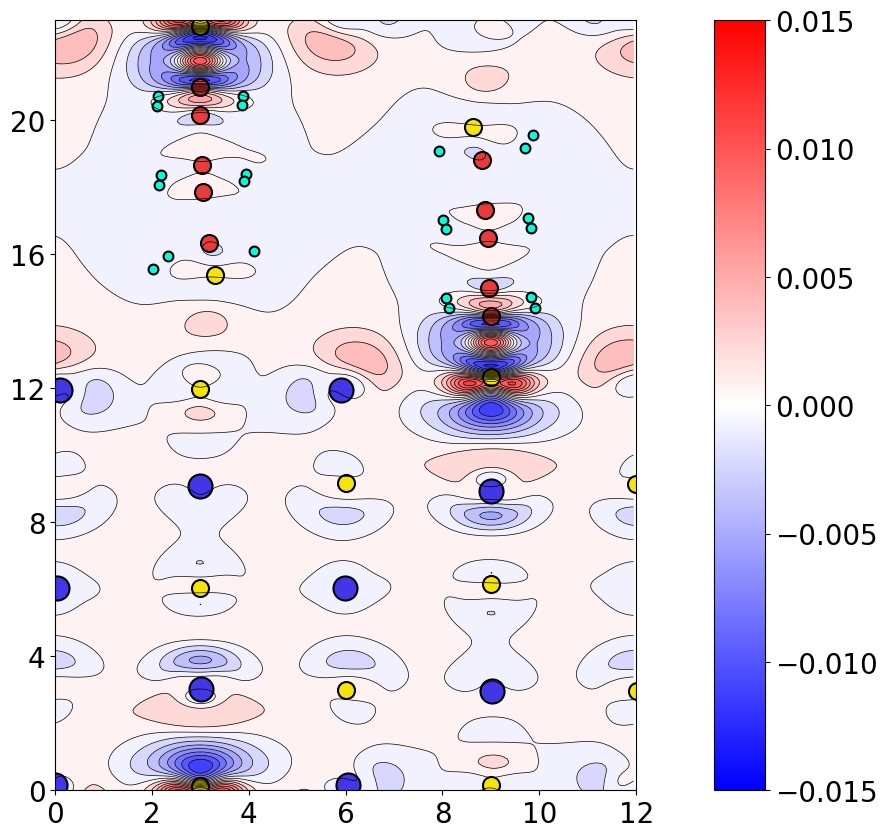

In [42]:
plot(X, Y, Z)